In [1]:
from elasticsearch import Elasticsearch
from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools

%matplotlib inline

In [2]:
es = Elasticsearch()
es

<Elasticsearch([{}])>

In [3]:
res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}})

In [4]:
def collect_all_results():
    res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}}, scroll='1m')
    scroll_id = res.get('_scroll_id')
    i = 1
    while scroll_id is not None:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id)
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
    return res
        

In [5]:
res = collect_all_results()

Processing scroll 1


# Total Associations

In [6]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

14750

In [7]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [8]:
count_attribute(res, 'source')

Counter({'cgi': 1429,
         'civic': 2713,
         'jax': 6513,
         'molecularmatch': 3116,
         'oncokb': 373,
         'pmkb': 606})

# Genes

In [9]:
%%capture
count_list_attribute(res, 'genes')

In [10]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [11]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({'cgi': 45, 'jax': 2492, 'molecularmatch': 215})

In [12]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [13]:
%%capture
mp_d

In [14]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [15]:
overlap(d)

cgi has 59/181 (32.60%) overlap with jax
cgi has 121/181 (66.85%) overlap with civic
cgi has 42/181 (23.20%) overlap with oncokb
cgi has 37/181 (20.44%) overlap with pmkb
cgi has 96/181 (53.04%) overlap with molecularmatch
cgi has 128/181 (70.72%) overlap overall
jax has 59/106 (55.66%) overlap with cgi
jax has 73/106 (68.87%) overlap with civic
jax has 30/106 (28.30%) overlap with oncokb
jax has 37/106 (34.91%) overlap with pmkb
jax has 64/106 (60.38%) overlap with molecularmatch
jax has 83/106 (78.30%) overlap overall
civic has 121/290 (41.72%) overlap with cgi
civic has 73/290 (25.17%) overlap with jax
civic has 42/290 (14.48%) overlap with oncokb
civic has 38/290 (13.10%) overlap with pmkb
civic has 140/290 (48.28%) overlap with molecularmatch
civic has 177/290 (61.03%) overlap overall
oncokb has 42/43 (97.67%) overlap with cgi
oncokb has 30/43 (69.77%) overlap with jax
oncokb has 42/43 (97.67%) overlap with civic
oncokb has 20/43 (46.51%) overlap with pmkb
oncokb has 41/43 (95.35%

In [16]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'])

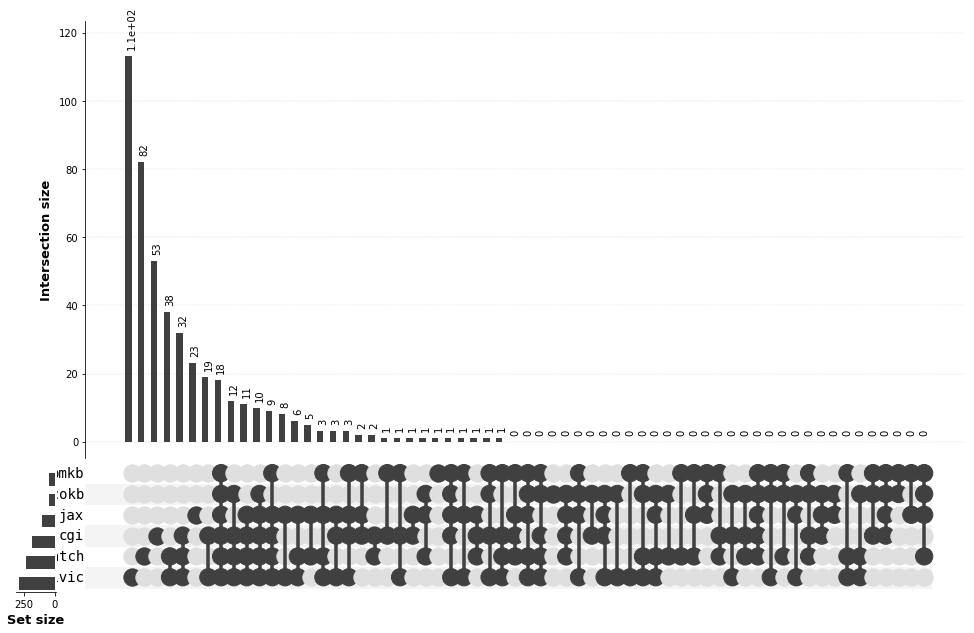

In [17]:
plot_overlap(d)

# Overlap of associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [18]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{'description': 'Imatinib',
  'id': 'compound:CID5291',
  'term': 'Imatinib',
  'toxicity': 'The most frequently reported adverse reactions (>30%) were edema, nausea,\r\nvomiting, muscle cramps, musculoskeletal pain, diarrhea, rash, fatigue and\r\nabdominal pain.'},
 {'description': 'inhibitor',
  'id': 'compound:CID657356',
  'term': 'inhibitor',
  'toxicity': 'unknown'},
 {'description': 'Clorazepate Dipotassium',
  'id': 'compound:CID23706210',
  'term': 'Clorazepate Dipotassium',
  'toxicity': 'unknown'}]

"Inhibitor" drug: https://pubchem.ncbi.nlm.nih.gov/compound/diacylglycerol_kinase_inhibitor_ii#section=Top

In [19]:
res['hits']['hits'][0]['_source']['cgi']

{'Alteration': 'ABL1:I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P,V371A,E373K,V379I,A380T,F382L,L384M,L387M,L387F,L387V,M388L,Y393C,H396P,H396R,H396A,A397P,S417F,S417Y,I418S,I418V,A433T,S438C,E450K,E450G,E450A,E450V,E453K,E453G,E453A,E453V,E459K,E459G,E459A,E459V,M472I,P480L,F486S,E507G',
 'Alteration type': 'MUT',
 'Assay type': '',
 'Association': 'Resistant',
 'Biomarker': 'ABL1 (I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P

In [20]:
def select_failures(hits):
    pheno_failed = 0
    drug_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            print( "Drug failure on ID {}".format( hit['_id'] ))
            drug_failed += 1
            drug = None
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if drug is None or phenotype is None:
            yield(hit)
        # yield (gene,drug,phenotype)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} hits with failed drug'.format(drug_failed))
    print('{} total hits'.format(len(hits)))

In [21]:
%%capture
failed = list(select_failures(res['hits']['hits']))

TypeError: sequence item 0: expected str instance, NoneType found

In [22]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

NameError: name 'failed' is not defined

In [ ]:
c = Counter([x['_source']['source'] for x in failed])
c

In [ ]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [ ]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

In [ ]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

# Overlap of associations (gene + phenotype)

In [ ]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [ ]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [ ]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

In [ ]:
c = Counter([x['_source']['source'] for x in failed])
c

In [ ]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

Prostate Adenocarcinoma?

In [ ]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

In [ ]:
cgi[0]['_source']['cgi']

In [ ]:
%%capture
set([x['_source']['association']['phenotype']['description'] for x in cgi])

In [ ]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        gene = '|'.join(sorted(hit['_source']['genes']))
        hit['merged'] = {'gene': gene}
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged']['phenotype'] = phenotype
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [ ]:
%%capture
successes = list(select_successes(res['hits']['hits']))

In [ ]:
s = Counter([x['_source']['source'] for x in successes])
s

In [ ]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [ ]:
%%capture
success_by_source

In [ ]:
overlap(success_by_source)

In [ ]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])


## Finding gene-PMID associations and comparing to gene-phenotype

This is some debugging code for issue 41: https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41

In [ ]:
double_listed_refs = Counter()
single_listed_refs = Counter()

listed_evidence = Counter()
single_evidence = Counter()
for hit in res['hits']['hits']:
    if isinstance(hit['_source']['association']['evidence'], list):
        listed_evidence[hit['_source']['source']] += 1
        for evidence in hit['_source']['association']['evidence']:
            for pmid_url in evidence['info']['publications']:
                if isinstance(pmid_url, list):
                    double_listed_refs[hit['_source']['source']] += 1
                else:
                    single_listed_refs[hit['_source']['source']] += 1
    else:
        single_evidence[hit['_source']['source']] += 1
        evidence = hit['_source']['association']['evidence']
        for pmid_url in evidence['info']['publications']:
            if isinstance(pmid_url, list):
                double_listed_refs[hit['_source']['source']] += 1
            else:
                single_listed_refs[hit['_source']['source']] += 1

In [ ]:
print(double_listed_refs)
print(single_listed_refs)
print(listed_evidence)
print(single_evidence)

First, we'll look at just PMID overlap

In [ ]:
pmid_re = re.compile(r'https?://www.ncbi.nlm.nih.gov/pubmed/(\d+)')
source_pmids = defaultdict(set)
single_url = Counter()
listed_url = Counter()
for hit in res['hits']['hits']:
    pmids = set()
    # next two lines fix double_listing, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
    if not isinstance(hit['_source']['association']['evidence'], list):
        hit['_source']['association']['evidence'] = [hit['_source']['association']['evidence']]
    for evidence in hit['_source']['association']['evidence']:
        urls = evidence['info']['publications']
    # next two lines fix single_evidence, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
        if isinstance(urls[0], list):
            urls = itertools.chain.from_iterable(urls)
        for pmid_url in urls:
            match = pmid_re.match(pmid_url)
            if match:
                pmids.add(match.groups()[0])
    urls = hit['_source']['association'].get('publication_url')
    # the following lines document differences in the structure of the publication_url field
    if not isinstance(urls, list):
        single_url[hit['_source']['source']] += 1
        urls = [urls]
    else:
        listed_url[hit['_source']['source']] += 1
    for url in urls:
        if url is None:
            continue
        match = pmid_re.match(url)
        if match:
            pmids.add(match.groups()[0])
    source_pmids[hit['_source']['source']] |= pmids
    pmids = list(pmids)
    if 'merged' in hit:
        hit['merged']['pmids'] = pmids
    else:
        hit['merged'] = {'pmids': pmids}
    

In [ ]:
{k: len(v) for k, v in source_pmids.items()}

In [ ]:
overlap(source_pmids)

In [ ]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(source_pmids)